<img src="https://i2.wp.com/www.ai-claudio.com/wp-content/uploads/2017/05/keras-tensorflow-logo.jpg?resize=500%2C201"/>

## Import required modules 

Install in swan the next dependencies running in the terminal

pip install scikit-learn dask[array]

In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Model Parameters
lr_init=1.e-3    Initial learning rate.<br>
batch_size=64   Batch size for gradient update during training.<br>
train_size=320  Training size per decay. max 160000 <br>
valid_size=44   Validation size per decay. max 44800 <br>
test_size=44    Test size per decay. max 44200 <br>
epochs=25 <br>
doGPU=False     Enable GPU memory optimizations. Requires tensorflow-gpu with cudnn <br>


In [2]:
lr_init=1.e-3
batch_size=64
train_size=320
valid_size=44
test_size=44
epochs=25
doGPU=False

In [3]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

## Load Image Data

In [4]:
### Load Image Data ###

img_rows, img_cols, nb_channels = 32, 32, 2
input_dir = 'IMG'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

## Configure Training/Validation and Tests Set

In [5]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available


## Plot  sample of training images

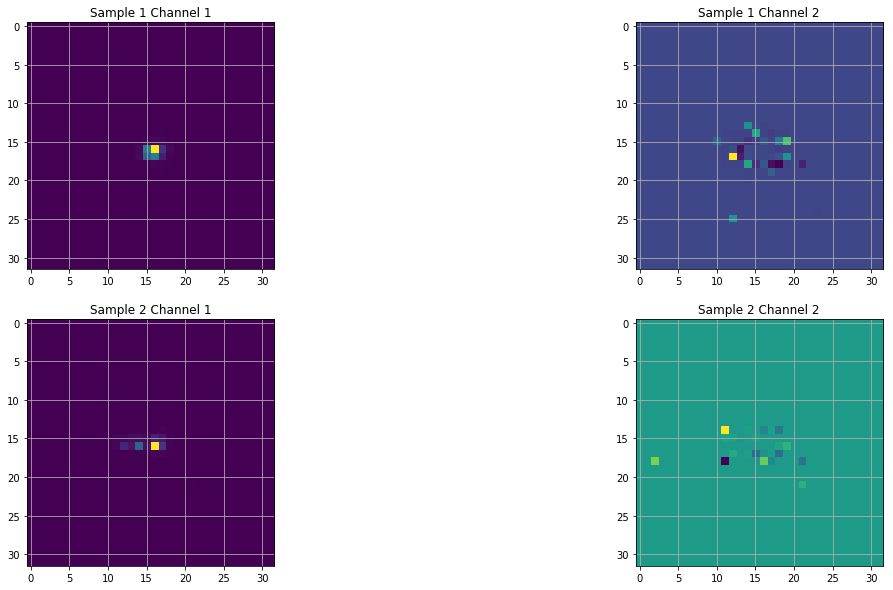

In [20]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Sample 1 Channel 1")
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Sample 1 Channel 2")
plt.grid(True)

plt.subplot(223)
plt.imshow(X_train[2,:,:,0])
plt.title("Sample 2 Channel 1")
plt.grid(True)

plt.subplot(224)
plt.imshow(X_train[2,:,:,1])
plt.title("Sample 2 Channel 2")
plt.grid(True)

plt.show()

## Define CNN Model

In [7]:
### Define CNN Model ###

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        304       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

### Train the Model

In [11]:
### Train Model ###

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 640 samples, validate on 88 samples
Epoch 1/25
640/640 [==============================] - 8s 13ms/step - loss: 0.4780 - acc: 0.7797 - val_loss: 0.7246 - val_acc: 0.6250
Epoch 2/25
640/640 [==============================] - 8s 13ms/step - loss: 0.4772 - acc: 0.7734 - val_loss: 0.7247 - val_acc: 0.6250
Epoch 3/25
640/640 [==============================] - 8s 12ms/step - loss: 0.4823 - acc: 0.7750 - val_loss: 0.7248 - val_acc: 0.6250
Epoch 4/25
640/640 [==============================] - 8s 12ms/step - loss: 0.4853 - acc: 0.7719 - val_loss: 0.7250 - val_acc: 0.6250
Epoch 5/25
640/640 [==============================] - 8s 13ms/step - loss: 0.4825 - acc: 0.7703 - val_loss: 0.7249 - val_acc: 0.6250
Epoch 6/25
640/640 [==============================] - 8s 13ms/step - loss: 0.4823 - acc: 0.7797 - val_loss: 0.7250 - val_acc: 0.6250
Epoch 7/25
640/640 [==============================] - 8s 13ms/step - loss: 0.4829 - acc: 0.7750 - val_loss: 0.7251 - val_acc: 0.6250
Epoch 8/25
640/640 [====

### Evaluate The Model

In [13]:
### Evaluate Model ###

# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

88/88 [==============================] - 0s 4ms/step

Validation loss / accuracy: 0.7261 / 0.6250
('Validation ROC AUC:', 0.66632231404958675)
88/88 [==============================] - 0s 4ms/step

Test loss / accuracy: 0.8273 / 0.5114
('Test ROC AUC:', 0.5449380165289256)


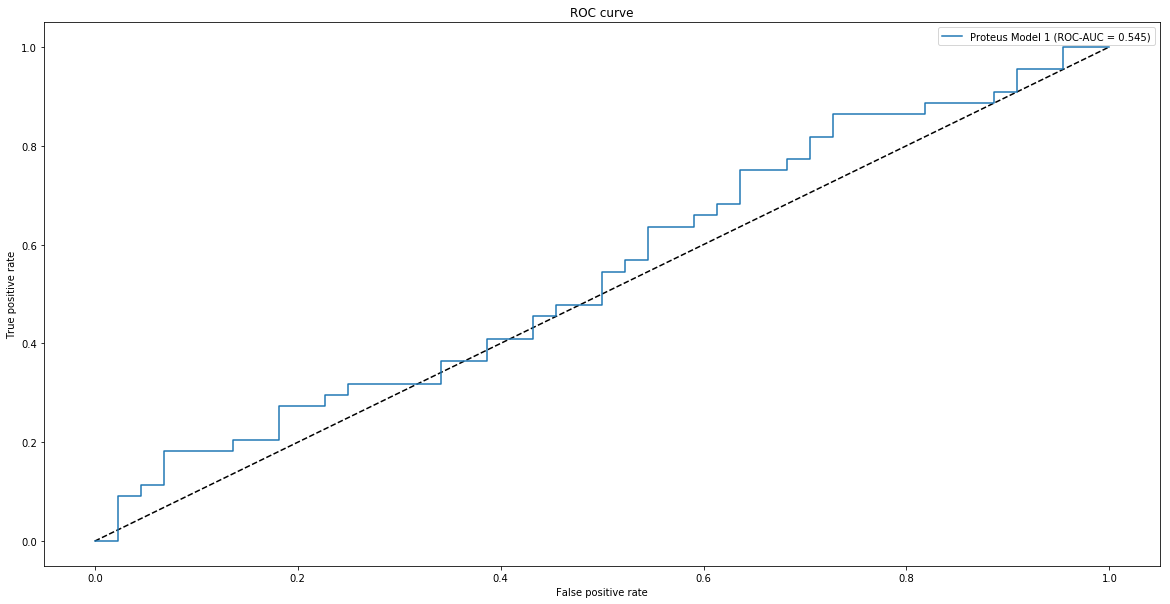

In [15]:
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Proteus Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()